- for fitness value: https://www.strava.com/fitness/97467?range=6months
- https://www.strava.com/fitness/97467?range=1year
but intermediate values ie 18months, 2year(s) doesnt work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from utils import get_strava_refresh_access_token, apply_pace_labels, get_strava_activity_data
from scipy.stats import pearsonr
from datetime import datetime
import matplotlib.image as mpimg
import textwrap
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%b-%Y")  # Format: Jan-2023

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# Convert Metrics


In [3]:
# Get access token
ACCESS_TOKEN = get_strava_refresh_access_token()

# Get all activities
activities = get_strava_activity_data(ACCESS_TOKEN)

# from meters to kilometers
df = activities.copy()
df['distance'] = round(df['distance'] / 1000, 2)

# Filter out low distance (also makes sure no division by zero, filters out Stepper etc.)
dist_thres = 3.0 # distance threshold in km
df = df[df["distance"] > dist_thres]  
print(f"{len(df)} activities left after filtering out < {dist_thres} km")

# from seconds to minutes
df['moving_time_min'] = round(df['moving_time'] / 60, 2)

# Fix start_date column into the correct format and set as index
df["start_date_local"] = pd.to_datetime(df['start_date_local'])
df.set_index("start_date_local", inplace=True)

# Change from m/s to km/h
df['max_speed'] = df['max_speed'] * 3.6
df['average_speed'] = df['average_speed'] * 3.6

# Calculate pace and transfer to seconds (for plotting mm:ss)
df['pace'] = df['moving_time_min'] / df['distance']
df["pace_sec"] = pd.to_timedelta(df["pace"] * 60, unit="s").dt.total_seconds()

# Save resulting df to csv
today = datetime.now().strftime('%d-%m-%Y')
spath = f"./data/strava_activities_overview_{today}.csv"
df.to_csv(spath, index=False)
print(f"saved data to {spath}")

# types of sport recorded
print(f"activity type: {df.type.unique()} \nactivity SPORT type: {df.sport_type.unique()}")
print(f"number of runs: {len(df[df.type.isin(['Run'])])}")

730 activities obtained from Strava API
517 activities left after filtering out < 3.0 km
saved data to ./data/strava_activities_overview_23-01-2025.csv
activity type: ['Run' 'Ride' 'Hike' 'Walk' 'Workout'] 
activity SPORT type: ['Run' 'Ride' 'Hike' 'TrailRun' 'Walk' 'GravelRide' 'Workout']
number of runs: 270


In [4]:
# Half Marathon PB
# df_sub = df.loc[(df.distance > 21) & (df.index.year == 2024) & (df.sport_type == "Run"), ["distance", "pace"]] # "start_date_local", 
# hm_dist, hm_pace = df_sub.iloc[0]
# hm_date = df_sub.index[0]

In [5]:
# Figure params
SAVE_FIGURE = True
results_save_path = "./results"
fdict = dict(fname=f"", dpi=600, bbox_inches="tight", edgecolor=None)

# Select Runs and TrailRuns
df_allruns = df[df.type.isin(["Run"])]  # df_allruns = df[df.sport_type.isin(["Run", "TrailRun"])] # type > Run, sort_type > Run, TrailRun
df_allruns = df_allruns[(df_allruns.index.year >= 2024)]

# Add pace in seconds
df_allruns["pace_sec"] = pd.to_timedelta(df_allruns["pace"] * 60, unit="s").dt.total_seconds()

# Progress
corr_coef, p_value = pearsonr(np.arange(len(df_allruns["pace"])), df_allruns["pace_sec"])
print(f"Pace vs Runs, Pearsons R: {np.round(corr_coef,3)} and p-val: {p_value}")
 
# Resample Distance per run
col = 'distance'
# Weekly
period = "W-MON"  # 2W, Bi-Weekly  # period = "M"  # MONTHLY
runs_weeks_dist = df_allruns.resample(period)[col].sum() # sum distance
# Daily
period = "D"
runs_days_dist = df_allruns.resample(period)[col].sum()


# Resample Pace per run
col = "pace_sec"
# 2 weeks
period = "2W-MON"
runs_2weeks_pace = df_allruns.resample(period)[col].median()
# Daily
period = "D"
runs_days_pace = df_allruns.resample(period)[col].mean()  # mean pace
# Rolling window
twindow = "14D"
min_periods = 1
pace_rollingx = runs_days_pace.rolling(window=twindow, min_periods=min_periods).median().index
pace_rollingy = runs_days_pace.rolling(window=twindow, min_periods=min_periods).median().values

Pace vs Runs, Pearsons R: 0.367 and p-val: 2.2034997329402354e-06


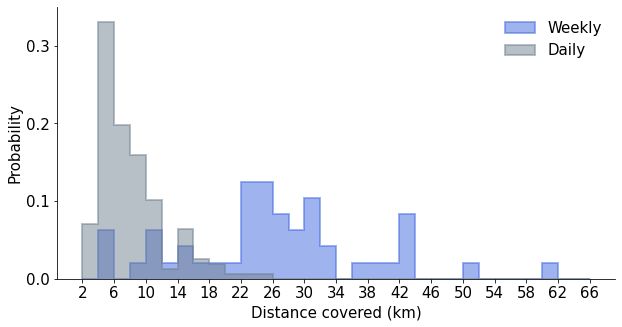

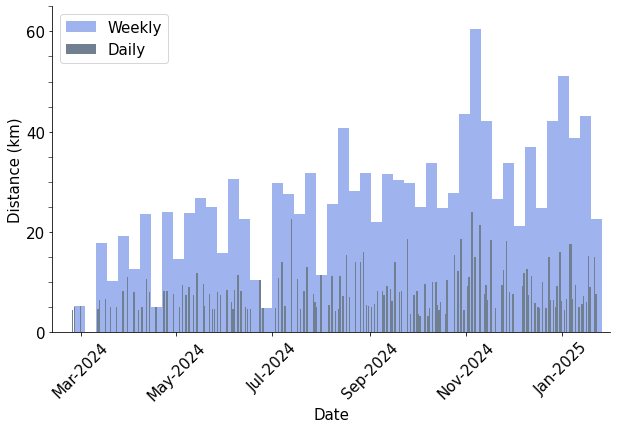

In [7]:
# Distance per run binning
bins = list(range(2, 68, 2))  # list(range(2, 44, 2))
binned_counts = pd.cut(df_allruns.distance, bins=bins, right=False).value_counts(normalize=True).sort_index()
binned_counts_weeks = pd.cut(pd.DataFrame(runs_weeks_dist).distance, bins=bins, right=False).value_counts(normalize=True).sort_index()

# Plotting
fdict["fname"] = f"{results_save_path}/distance-per-run-histogram-2024-and-onwards.jpg"
ax_params = dict(xlabel="Distance covered (km)", ylabel="Probability", ylim=(0, 0.35), yticks=np.arange(0, 0.3+0.1, 0.1), xticks=bins[::2])

fig, ax = plt.subplots(figsize=(10, 5))
ax.stairs(binned_counts_weeks.values, bins, alpha=0.5, label="Weekly", fill=True, color="royalblue", edgecolor="royalblue", linewidth=2)
ax.stairs(binned_counts.values, bins, alpha=0.5, label="Daily", fill=True, color="slategray", edgecolor="slategray", linewidth=2)
ax.legend(frameon=False)
ax.set(**ax_params);#ylabel="µm s$^{-1}$")
fig.savefig(**fdict) if SAVE_FIGURE else None

# Plotting
fdict["fname"] = f"{results_save_path}/daily-and-summed-distance-per-run-timeline-2024-onwards.jpg"
ax_params = dict(ylabel="Distance (km)", ylim=(0,65), yticks=range(0, 65+1, 20), xlabel="Date", xlim=(pd.Timestamp("2024-02-12"), pd.Timestamp("2025-02")))

fig, ax = plt.subplots(figsize=(10,6))
ax.stairs(list(runs_weeks_dist.values)[1:],list(runs_weeks_dist.index), alpha=.5, label="Weekly", fill=True, color="royalblue", edgecolor=None)
ax.bar(runs_days_dist.index, runs_days_dist.values, width=.9, color="slategray", label="Daily")
# Axes stuff
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45);
ax.tick_params(axis='y', which='minor', length=4)
ax.set(**ax_params)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_formatter(date_format)
ax.legend(loc="upper left");
fig.savefig(**fdict) if SAVE_FIGURE else None

# pace_sec

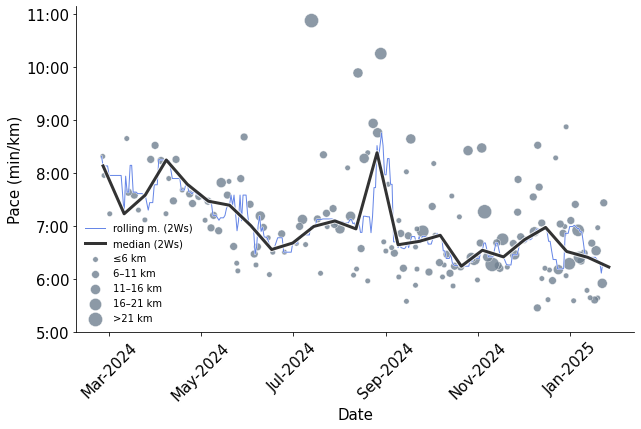

In [8]:
# Define marker sizes based on distance ranges
marker_sizes = []
for dist in df_allruns["distance"]:
    if dist <= 6:
        marker_sizes.append(30)
    elif 6 < dist <= 11:
        marker_sizes.append(60)
    elif 11 < dist <= 16:
        marker_sizes.append(100)
    elif 16 < dist <= 21:
        marker_sizes.append(150)
    else:
        marker_sizes.append(200)

legend_sizes = [30, 60, 100, 150, 200]
labels = ["≤6 km", "6–11 km", "11–16 km", "16–21 km", ">21 km"]

# Plotting
pace_labels = dict(min_pace="5:00", max_pace="11:00", step="1:00", axis="y")
fdict["fname"] = f"{results_save_path}/pace-progression-2W-window-2024.jpg"

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pace_rollingx, pace_rollingy, "-", color="w", lw=2, alpha=.8)
ax.plot(pace_rollingx, pace_rollingy, "-", color="royalblue", lw=1, alpha=.8, label="rolling m. (2Ws)")
ax.plot(runs_2weeks_pace.index, runs_2weeks_pace.values, "-", lw=5, alpha=.8, color="white")
ax.plot(runs_2weeks_pace.index, runs_2weeks_pace.values, "-", lw=3, alpha=.8, color="k", label="median (2Ws)")

ax.scatter(df_allruns.index, df_allruns["pace_sec"], s=marker_sizes, c="slategray", alpha=.8, edgecolors="w", linewidths=.5)
#ax.plot(hm_date, hm_pace, "o", color="gold", ms=20, mfc="none", mew=2, label=f"Half Marathon PB")
for size, label in zip(legend_sizes, labels):
    ax.scatter([], [], s=size, c="slategray", alpha=0.8, edgecolors="w", label=label, linewidths=.5)

# Axes stuff
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45);
ax.xaxis.set_major_formatter(date_format)
apply_pace_labels(ax, **pace_labels)
ax.set(ylabel="Pace (min/km)", xlabel="Date");
ax.legend(fontsize=10, loc="lower left", frameon=False)
fig.savefig(**fdict) if SAVE_FIGURE else None

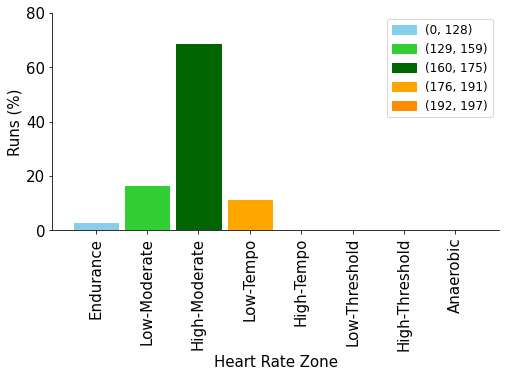

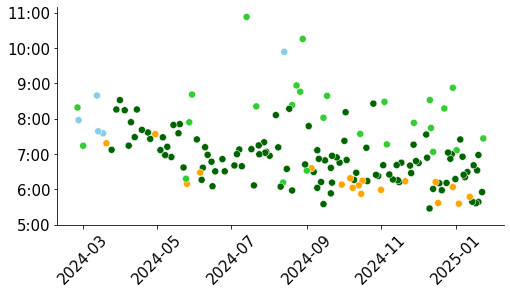

In [9]:
# Define heart rate zones and labels
hr_zones = [(0, 128), (129, 159), (160, 175), (176, 191), (192, 197)]
hr_zones_ = [(0, 128), (129, 144), (145, 159), (160, 167), (168, 175), (176, 183), (184, 191), (192, 197)]

hr_zone_labels = ["Endurance", "Moderate", "Tempo", "Threshold", "Anaerobic"]
hr_zone_labels_ = ["Endurance", "Low-Moderate", "High-Moderate", "Low-Tempo", "High-Tempo", "Low-Threshold", "High-Threshold", "Anaerobic"]
hr_zone_colors = ["skyblue", "limegreen", "darkgreen", "orange", "darkorange", "orangered", "red", "darkred"]

# Bin heart rate into zones with labels
#df_stream["hr_zone"] = pd.cut(df_stream["heartrate"], bins=[z[0] for z in hr_zones] + [hr_zones[-1][1]], labels=hr_zone_labels)
df_allruns["hr_zone_"] = pd.cut(df_allruns["average_heartrate"], bins=[z[0] for z in hr_zones_] + [hr_zones_[-1][1]], labels=hr_zone_labels_)
df_allruns["hr_zone_color"] = pd.cut(df_allruns["average_heartrate"], bins=[z[0] for z in hr_zones_] + [hr_zones_[-1][1]], labels=hr_zone_colors)

# Calculate relative time spent in each zone
zone_counts = df_allruns["hr_zone_"].value_counts(normalize=True).sort_index() * 100
x, y = zone_counts.index, zone_counts.values

# Legend
from matplotlib.patches import Patch
custom_legend = [Patch(color=c, label=f"{hrz}") for c, hrz in zip(hr_zone_colors, hr_zones)]

# Plotting
fdict["fname"] = f"{results_save_path}/heart-rate-zone-per-run-histogram.jpg"

fig, ax = plt.subplots()
ax.bar(x, y, color=hr_zone_colors, edgecolor="white", width=.9)
plt.xticks(rotation=90)
ax.set(ylabel="Runs (%)", xlabel="Heart Rate Zone", ylim=(0, 80), yticks=range(0, 80+1, 20));
ax.legend(handles=custom_legend, fontsize=12)
fig.savefig(**fdict) if SAVE_FIGURE else None

# Plotting
fdict["fname"] = f"{results_save_path}/heart-rate-zone-progression.jpg"

fig, ax = plt.subplots()
ax.scatter(df_allruns.index, df_allruns["pace_sec"], c=df_allruns["hr_zone_color"], s=50, edgecolors="w", linewidths=.5)
apply_pace_labels(ax, **pace_labels)
plt.xticks(rotation=45);
fig.savefig(**fdict) if SAVE_FIGURE else None

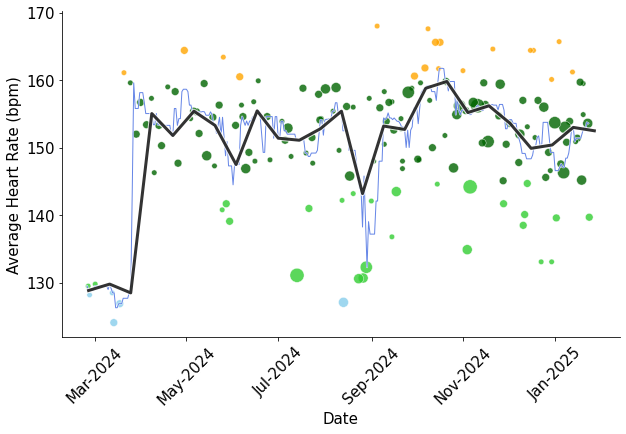

In [10]:
# Resample Heart Rate per run
period = "2W-MON"
col = 'average_heartrate'
runs_2weeks_hr = df_allruns.resample(period)[col].median()
# Daily
period = "D"
runs_daily_hr = df_allruns.resample(period)[col].mean()  # mean HR
twindow = "14D"
min_periods = 1
hrrollingx = runs_daily_hr.rolling(window=twindow, min_periods=min_periods).median().index
hrrollingy = runs_daily_hr.rolling(window=twindow, min_periods=min_periods).median().values

# Plotting
fdict["fname"] = f"{results_save_path}/heart-rate-progression-hrzone-colored.jpg"

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(hrrollingx, hrrollingy, "-", color="w", lw=2, alpha=.8)
ax.plot(hrrollingx, hrrollingy, "-", color="royalblue", lw=1, alpha=.8, label="rolling m. (2Ws)")
ax.plot(runs_2weeks_hr.index, runs_2weeks_hr.values, "-", lw=5, alpha=.8, color="white")
ax.plot(runs_2weeks_hr.index, runs_2weeks_hr.values, "-", lw=3, alpha=.8, color="k", label="median (2Ws)")
ax.scatter(df_allruns.index, df_allruns["average_heartrate"], s=marker_sizes, c=df_allruns["hr_zone_color"], alpha=.8, edgecolors="w", linewidths=.5)

for size, label in zip(legend_sizes, labels):
    ax.scatter([], [], s=size, alpha=0.8, edgecolors="w", label=label)

ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45);
ax.set(ylabel="Average Heart Rate (bpm)", xlabel="Date")
ax.xaxis.set_major_formatter(date_format)
fig.savefig(**fdict) if SAVE_FIGURE else None

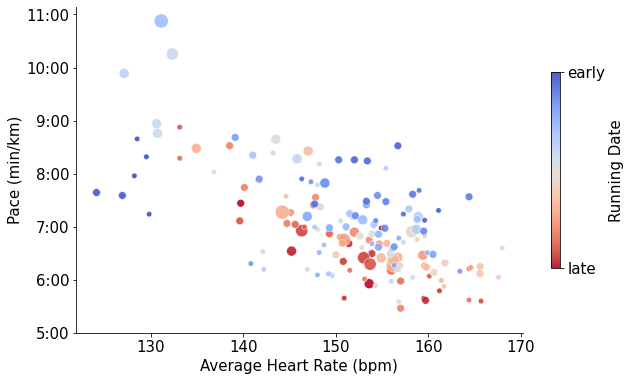

In [11]:
# runs sorted by date
cs = np.arange(0, len(df_allruns))

# Plotting
fdict["fname"] = f"{results_save_path}/pace-vs-heart-rate-progression-date-colored.jpg"

fig, ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(df_allruns["average_heartrate"], df_allruns["pace_sec"], s=marker_sizes, c=cs, alpha=.9, edgecolors="w", cmap="coolwarm_r", linewidths=.5)
apply_pace_labels(ax, **pace_labels)
ax.set(xlabel="Average Heart Rate (bpm)", ylabel="Pace (min/km)")
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_ticks([cs.min(), cs.max()])
cbar.set_ticklabels(["late", "early"])
cbar.set_label("Running Date")
fig.savefig(**fdict) if SAVE_FIGURE else None

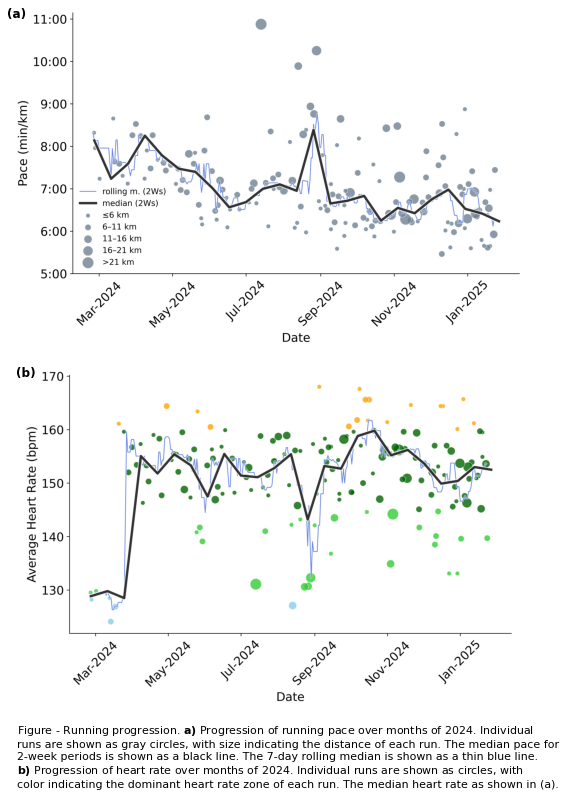

In [27]:
images = [f"{results_save_path}/pace-progression-2W-window-2024.jpg", f"{results_save_path}/heart-rate-progression-hrzone-colored.jpg"]
panel_labels = ["(a)", "(b)"] # , "(c)", "(d)"

fig, axes = plt.subplots(2, 1, figsize=(10, 12))
for ax, img_path, label in zip(axes.flatten(), images, panel_labels):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")  # Hide axis ticks
    ax.text(-.01, 0.999, label, transform=ax.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")  # Add label

legend_text = r"""
Figure - Running progression. $\bf{a)}$ Progression of running pace over months of 2024. Individual runs are shown as gray circles, with size indicating the distance of each run. The median pace for 2-week periods is shown as a black line. The 7-day rolling median is shown as a thin blue line. $\bf{b)}$ Progression of heart rate over months of 2024. Individual runs are shown as circles, with color indicating the dominant heart rate zone of each run. The median heart rate as shown in (a).
"""
wrapped_text = "\n".join(textwrap.fill(line, width=100) for line in legend_text.splitlines() if line.strip())

fig.text(0.15, 0.025, wrapped_text, ha="left", va="bottom", fontsize=11, linespacing=1.25)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
fig.savefig(f"{results_save_path}/compound-figure-Pace-HR-Progression.jpg", dpi=1200, bbox_inches="tight")  # High DPI for quality

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_41109/4155458513.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


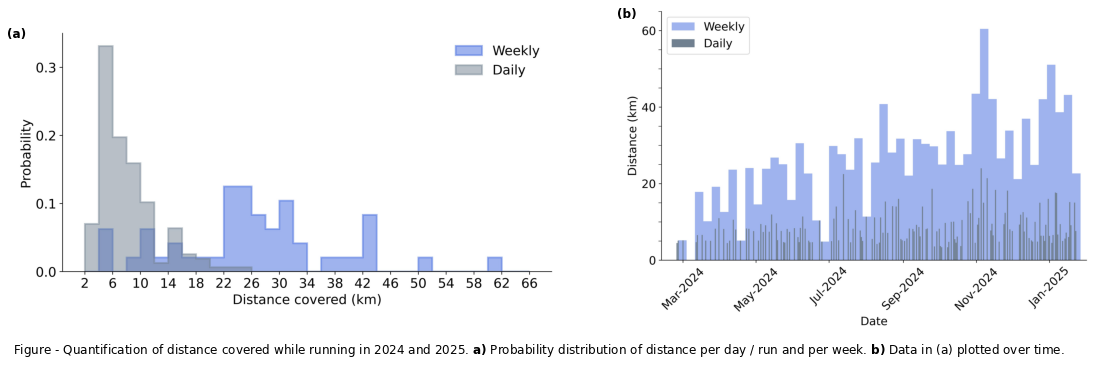

In [28]:
images = [f"{results_save_path}/distance-per-run-histogram-2024-and-onwards.jpg", f"{results_save_path}/daily-and-summed-distance-per-run-timeline-2024-onwards.jpg"]
panel_labels = ["(a)", "(b)"]

# decrease distance between subfigures
fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={"wspace": 0.05})  
for ax, img_path, label in zip(axes.flatten(), images, panel_labels):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")  # Hide axis ticks
    ax.text(-.01, 0.999, label, transform=ax.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")  # Add label

legend_text = r"""
Figure - Quantification of distance covered while running in 2024 and 2025. $\bf{a)}$ Probability distribution of distance per day / run and per week. $\bf{b)}$ Data in (a) plotted over time.
"""
wrapped_text = "\n".join(textwrap.fill(line, width=200) for line in legend_text.splitlines() if line.strip())

fig.text(0.125, 0.065, wrapped_text, ha="left", va="bottom", fontsize=12, linespacing=1.25)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
fig.savefig(f"{results_save_path}/compound-figure-running-distance.jpg", dpi=1200, bbox_inches="tight")

# Pace Zones
- TO DO > min.sec to sec

In [29]:
# # Define pace zones (monotonically decreasing)
# pace_zones = [
#     (7.27, float("inf")),  # Zone 1: Recovery (slowest)
#     (7.26, 6.24),             # Zone 2: Endurance
#     (6.24, 5.45),             # Zone 3: Tempo
#     (5.45, 5.23),             # Zone 4: Threshold
#     (5.23, 5.03),             # Zone 5: VO2Max
#     (5.03, 0.5),              # Zone 6: Anaerobic / Sprint (fastest)
# ]
# bins = [z[1] for z in pace_zones[::-1]] + [pace_zones[0][0]]
# bins = sorted(bins)  # Ensure bins are monotonically increasing

# # Zone labels (one less than the number of bins)
# #zone_labels = [f"Zone {len(pace_zones) - i}" for i in range(len(pace_zones))]
# zone_labels = [int(len(pace_zones) - i) for i in range(len(pace_zones))]

# # Assign zones using pd.cut
# df_allruns["pace_zone"] = pd.cut(df_allruns["pace_sec"].values / 60, bins=bins, labels=zone_labels, right=False)
# # have to get rid of first value of pace > indeed no data
# #df["pace_zone"] = df["pace_zone"].astype(int)
# df_allruns["pace_zone"].unique()

# # Calculate relative time spent in each zone
# zone_counts = df_allruns["pace_zone"].value_counts(normalize=True) * 100
# zone_counts = zone_counts.sort_index()

# x, y = zone_counts.index, zone_counts.values

# plt.figure(figsize=(8, 6))
# plt.bar(x, y, color="skyblue", edgecolor="black", width=1)